# Meta Learning

## Model Agnostic Meta-Learning (MAML)

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


Video:
https://youtu.be/_QPMCDdFC3E

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Other dependencies
import random
import sys
import os
import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt

print('Python version: ', sys.version)
print('Pytorch version: ', torch.__version__)

print("GPU available: {}".format(torch.cuda.is_available()))
print("current GPU index: {}".format(torch.cuda.current_device()))
print("current GPU card name: {}".format(torch.cuda.get_device_name(0)))

Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Pytorch version:  1.10.0+cu111
GPU available: True
current GPU index: 0
current GPU card name: Tesla K80


## Prepare dataset

### Omniglot Dataset

The Omniglot handwritten character dataset is a dataset for one-shot learning, proposed by Lake et al. It contains 1623 different handwritten characters from 50 different series of alphabets, where each character was handwritten by 20 different people. Each image is 105x105 pixels large. The 50 alphabets are divided into a 30:20 ratio for training and testing, which means that the test set is on a completely new set of characters that are unseen before.
<center><img src="https://i2.wp.com/hugrypiggykim.com/wp-content/uploads/2018/10/omniglot_dataset_characters.jpeg?resize=635%2C289"></center>

https://www.kaggle.com/watesoyan/omniglot

In [2]:
# download omniglot dataset
torchvision.datasets.Omniglot('omniglot', background=True, download=True)
torchvision.datasets.Omniglot('omniglot', background=False, download=True)
;

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_background.zip to omniglot/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_evaluation.zip to omniglot/omniglot-py


''

#### What is few-shot learning?
<center><img src="https://blog.kakaocdn.net/dn/RaOdb/btqwWojdR2B/lAkovlKlD4oYyJnE3ko0PK/img.png"></center>

### Build N-way K-shot Dataset


In [3]:
class myOmniglot(Dataset):
  def __init__(self, root, train, nway, kshot, nquery, nepisode, transform):
    self.train = train
    # nway: number of classes
    self.nway = nway
    # kshot: number of images per class
    self.kshot = kshot
    # nquery: number of images per class to test
    self.nquery = nquery
    # nepisode: total number of episode
    self.nepisode = nepisode
    self.transform = transform

    # TODO 1. compose char2fnames (e.g. {'korean_character0': ['a.jpg', 'b.jpg', ...]})
    self.char2fnames = dict()
    data_dir = os.path.join(root,
                            'omniglot-py', 
                            'images_background' if self.train else 'images_evaluation')
    
    for language in os.listdir(data_dir):
      lang_dir = os.path.join(data_dir, language)
      for character in os.listdir(lang_dir):
        char_dir = os.path.join(lang_dir, character)
        unique_char = '_'.join([language, character])
        for fname in os.listdir(char_dir):
          file_path = os.path.join(char_dir, fname)
          if unique_char not in self.char2fnames:
            self.char2fnames[unique_char] = list()
          self.char2fnames[unique_char].append(file_path)

  def __len__(self):
    return self.nepisode

  def __getitem__(self, idx):
    # TODO 2. sample n classes (nway)
    chars = random.sample(self.char2fnames.keys(), self.nway)
    
    spt_imgs, spt_labels = [], []
    qry_imgs, qry_labels = [], []
    for i, char in enumerate(chars):
      # TODO 3. sample one example for support & n examples for query
      file_paths = random.sample(self.char2fnames[char], self.kshot + self.nquery)

      # TODO 4. support examples
      for file_path in file_paths[:self.kshot]:
        spt_img = self.transform(Image.open(file_path))
        spt_imgs.append(spt_img)
        spt_labels.append(i)

      # TODO 5. query examples
      for file_path in file_paths[self.kshot:]:
        qry_img = self.transform(Image.open(file_path))
        qry_imgs.append(qry_img)
        qry_labels.append(i)

    # stack images, concat labels
    spt_imgs = torch.stack(spt_imgs, dim=0)
    spt_labels = torch.LongTensor(spt_labels)

    qry_imgs = torch.stack(qry_imgs, dim=0)
    qry_labels = torch.LongTensor(qry_labels)

    # shuffle spt images, spt labels
    qry_shuffle_list = list(range(len(qry_imgs)))
    random.shuffle(qry_shuffle_list)

    qry_imgs = qry_imgs[qry_shuffle_list]
    qry_labels = qry_labels[qry_shuffle_list]

    return spt_imgs, spt_labels, qry_imgs, qry_labels

In [4]:
train_dataset = myOmniglot('./omniglot', train=True, nway=5, kshot=5, nquery=15, nepisode=10000, transform=transforms.ToTensor())

In [5]:
test_dataset = myOmniglot('./omniglot', train=False, nway=5, kshot=5, nquery=15, nepisode=500, transform=transforms.ToTensor())

spt_imgs.shape: torch.Size([25, 1, 105, 105])
spt_labels.shape: torch.Size([25])
qry_imgs.shape: torch.Size([75, 1, 105, 105])
qry_labels.shape: torch.Size([75])


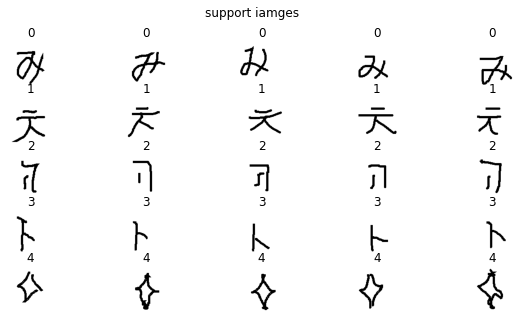

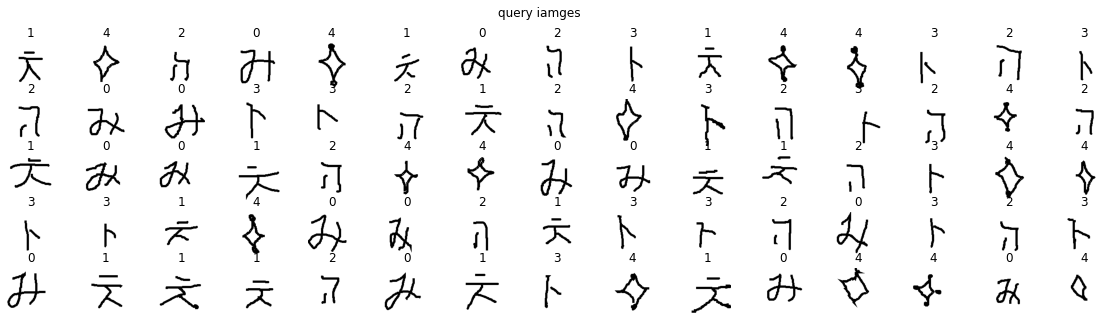

In [6]:
idx = 100

spt_imgs, spt_labels, qry_imgs, qry_labels = train_dataset[idx]
print("spt_imgs.shape: {}".format(spt_imgs.shape))
print("spt_labels.shape: {}".format(spt_labels.shape))
print("qry_imgs.shape: {}".format(qry_imgs.shape))
print("qry_labels.shape: {}".format(qry_labels.shape))

toPILImage = transforms.ToPILImage('L')

plt.figure(figsize=(10, 5))
plt.suptitle('support iamges')
for i in range(len(spt_imgs)):
  plt.subplot(5, 5, i + 1)
  plt.imshow(toPILImage(spt_imgs[i]), cmap='gray')
  plt.axis('off')
  plt.title(spt_labels[i].item())
plt.show()

plt.figure(figsize=(20, 5))
plt.suptitle('query iamges')
for i in range(len(qry_imgs)):
  plt.subplot(5, 15, i + 1)
  plt.imshow(toPILImage(qry_imgs[i]), cmap='gray')
  plt.axis('off')
  plt.title(qry_labels[i].item())
plt.show()

#### Model definition


> *Our model follows the same architecture as the embedding
function used by Vinyals et al. (2016), which has 4 modules with a 3 × 3 convolutions and 64 filters, followed by
batch normalization (Ioffe & Szegedy, 2015), a ReLU nonlinearity, and 2 × 2 max-pooling. For Omniglot, we used strided convolutions instead
of max-pooling.*

In [ ]:
# TODO 1. build your model following the instruction above.
class Net(nn.Module):
  def __init__(self, nclasses):
      super(Net, self).__init__()
      # Conv2d(input_channels, output_channels, kernel_size)
      self.conv1 = nn.Conv2d(1, 64, 3, 2) 
      self.bn1 = nn.BatchNorm2d(64)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(64, 64, 3, 2)  
      self.bn2 = nn.BatchNorm2d(64)
      self.relu2 = nn.ReLU()
      self.conv3 = nn.Conv2d(64, 64, 3, 2)
      self.bn3 = nn.BatchNorm2d(64)
      self.relu3 = nn.ReLU()
      self.conv4 = nn.Conv2d(64, 64, 3, 2)
      self.bn4 = nn.BatchNorm2d(64)
      self.relu4 = nn.ReLU()

      self.flatten = nn.Flatten()
      self.fc = nn.Linear(1600, nclasses)

  def forward(self, img):
      x = self.conv1(img)
      x = self.bn1(x)
      x = self.relu1(x)
      
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu2(x)
      
      x = self.conv3(x)
      x = self.bn3(x)
      x = self.relu3(x)
      
      x = self.conv4(x)
      x = self.bn4(x)
      x = self.relu4(x)

      x = self.flatten(x)
      x = self.fc(x)
      return x

In [ ]:
spt_imgs, spt_labels, qry_imgs, qry_labels = train_dataset[100]

model = Net(5)
output = model(spt_imgs[0].unsqueeze(0))
output

tensor([[ 0.4985, -0.1324,  0.0843,  0.2663,  0.0102]],
       grad_fn=<AddmmBackward>)

In [ ]:
class Net(nn.Module):
  def __init__(self, nclasses):
      super(Net, self).__init__()
      # TODO 1. copy code from the above cell
      self.conv1 = nn.Conv2d(1, 64, 3, 2) 
      self.bn1 = nn.BatchNorm2d(64)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(64, 64, 3, 2)  
      self.bn2 = nn.BatchNorm2d(64)
      self.relu2 = nn.ReLU()
      self.conv3 = nn.Conv2d(64, 64, 3, 2)
      self.bn3 = nn.BatchNorm2d(64)
      self.relu3 = nn.ReLU()
      self.conv4 = nn.Conv2d(64, 64, 3, 2)
      self.bn4 = nn.BatchNorm2d(64)
      self.relu4 = nn.ReLU()

      self.flatten = nn.Flatten()
      self.fc = nn.Linear(1600, nclasses)

  def forward(self, img):
      # TODO 2. copy code from the above cell
      x = self.conv1(img)
      x = self.bn1(x)
      x = self.relu1(x)
      
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu2(x)
      
      x = self.conv3(x)
      x = self.bn3(x)
      x = self.relu3(x)
      
      x = self.conv4(x)
      x = self.bn4(x)
      x = self.relu4(x)

      x = self.flatten(x)
      x = self.fc(x)
      return x

  def forward_external_weights(self, img, weights):
    x = F.conv2d(img, weights[0], weights[1], stride=self.conv1.stride, padding=self.conv1.padding)
    x = F.batch_norm(x, self.bn1.running_mean, self.bn1.running_var, weights[2], weights[3], training=True)
    x = F.relu(x)

    x = F.conv2d(x, weights[4], weights[5], stride=self.conv2.stride, padding=self.conv2.padding)
    x = F.batch_norm(x, self.bn2.running_mean, self.bn2.running_var, weights[6], weights[7], training=True)
    x = F.relu(x)

    x = F.conv2d(x, weights[8], weights[9], stride=self.conv3.stride, padding=self.conv3.padding)
    x = F.batch_norm(x, self.bn3.running_mean, self.bn3.running_var, weights[10], weights[11], training=True)
    x = F.relu(x)

    x = F.conv2d(x, weights[12], weights[13], stride=self.conv4.stride, padding=self.conv4.padding)
    x = F.batch_norm(x, self.bn4.running_mean, self.bn4.running_var, weights[14], weights[15], training=True)
    x = F.relu(x)
  
    x = self.flatten(x)
    x = F.linear(x, weights[16], weights[17])
    return x

In [ ]:
model = Net(5)
output = model.forward_external_weights(spt_imgs[0].unsqueeze(0), list(model.parameters()))
output

tensor([[-0.2158,  0.0464,  0.6643,  0.2339, -0.5309]],
       grad_fn=<AddmmBackward>)

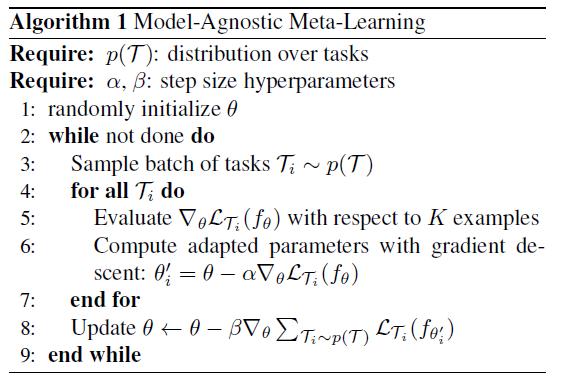

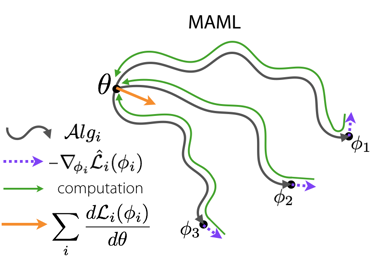

In [ ]:
NTASKS = 32
NEPOCHS = 200
LR = 0.001
N_TRAIN_INNER_STEP = 1
N_TEST_INNER_STEP = 3
N_INNER_LR = 0.4

In [ ]:
model = Net(5)
criterion = nn.CrossEntropyLoss()

model.to("cuda:0")
criterion.to('cuda:0')

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NEPOCHS)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=NTASKS, num_workers=8, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_dataloader))
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


4
torch.Size([32, 25, 1, 105, 105])
torch.Size([32, 25])
torch.Size([32, 75, 1, 105, 105])
torch.Size([32, 75])


In [ ]:
def train(dataloader, model, criterion, optimizer):
  model.train()
  for spt_x, spt_y, qry_x, qry_y in tqdm.notebook.tqdm(train_dataloader, desc='train'):
    optimizer.zero_grad()
    total_loss = 0
    for itask in range(NTASKS):
      # move to GPU
      spt_imgs = spt_x[itask].cuda()
      spt_labels = spt_y[itask].cuda()
      qry_imgs = qry_x[itask].cuda()
      qry_labels = qry_y[itask].cuda()

      # calculate loss of spt_imgs
      logits = model(spt_imgs)
      loss = criterion(logits, spt_labels)

      # update model's parameters externally
      grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
      weights = [p - N_INNER_LR * g for p, g in zip(model.parameters(), grads)]
      
      # repeat inner loop process
      for istep in range(1, N_TRAIN_INNER_STEP):
        logits = model.forward_external_weights(spt_imgs, weights)
        loss = criterion(logits, spt_labels)
        grads = torch.autograd.grad(loss, weights, create_graph=True)
        weights = [p - N_INNER_LR * g for p, g in zip(model.parameters(), grads)]

      # calculate loss of qry_imgs with updated parameters
      qry_logits = model.forward_external_weights(qry_imgs, weights)
      loss = criterion(qry_logits, qry_labels)

      total_loss = total_loss + loss
    
    total_loss = total_loss / NTASKS
    total_loss.backward()
    # update model's parameters
    optimizer.step()

In [ ]:
def test(dataloader, model, criterion):
  model.eval()
  test_loss = 0
  test_acc = 0
  test_n = 0
  for data in tqdm.notebook.tqdm(train_dataloader, desc='test'):
    spt_imgs = data[0][0].cuda()
    spt_labels = data[1][0].cuda()
    qry_imgs = data[2][0].cuda()
    qry_labels = data[3][0].cuda()

    # TODO 1. adapt to support data
    logits = model(spt_imgs)
    loss = criterion(logits, spt_labels)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=False)
    weights = [p - N_INNER_LR * g for p, g in zip(model.parameters(), grads)]
    for istep in range(1, N_TEST_INNER_STEP):
      logits = model.forward_external_weights(spt_imgs, weights)
      loss = criterion(logits, spt_labels)
      grads = torch.autograd.grad(loss, weights, create_graph=False)
      weights = [p - N_INNER_LR * g for p, g in zip(model.parameters(), grads)]

    with torch.no_grad():
      # TODO 2. calculate query loss
      logits = model.forward_external_weights(qry_imgs, weights)
      loss = criterion(logits, qry_labels)

      # TODO 3. calculate query acc
      pred = torch.argmax(logits, dim=1)
      acc = torch.sum(pred == qry_labels)
      test_loss += loss.item() * len(qry_imgs)
      test_acc += acc.item()
      test_n += len(qry_imgs)

  test_loss /= test_n
  test_acc /= test_n

  print(f'EPOCH {epc}/{NEPOCHS}:\t test loss: {test_loss}\t test acc: {test_acc}')

In [ ]:
for epc in range(NEPOCHS):
  train(train_dataloader, model, criterion, optimizer)
  scheduler.step()
  test(test_dataloader, model, criterion)

train:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test:   0%|          | 0/312 [00:00<?, ?it/s]

EPOCH 0/200:	 test loss: 12.654719965580183	 test acc: 0.31722222222222224


train:   0%|          | 0/312 [00:00<?, ?it/s]

test:   0%|          | 0/312 [00:00<?, ?it/s]

EPOCH 1/200:	 test loss: 9.121457718867951	 test acc: 0.5014102564102564


train:   0%|          | 0/312 [00:00<?, ?it/s]

### Practice: Build new model and meta-train it

#### Task
5 way 5 shot omniglot classification

#### Model definition
> We also provide results for a non-convolutional network. For this, we use a
network with 4 hidden layers with sizes 256, 128, 64, 64,
each including batch normalization and ReLU nonlinearities, followed by a linear layer and softmax. ... The Omniglot images
are downsampled to 28 × 28. 



In [ ]:
# TODO 1. complete code
class Net(nn.Module):
  def __init__(self, nclasses):
      super(Net, self).__init__()
      
      # Conv2d(input_channels, output_channels, kernel_size)
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(28*28, 256)
      self.bn1 = nn.BatchNorm1d(256)
      self.relu1 = nn.ReLU()
      
      self.fc2 = nn.Linear(256, 128)
      self.bn2 = nn.BatchNorm1d(128)
      self.relu2 = nn.ReLU()

      self.fc3 = nn.Linear(128, 64)
      self.bn3 = nn.BatchNorm1d(64)
      self.relu3 = nn.ReLU()

      self.fc4 = nn.Linear(64, 64)
      self.bn4 = nn.BatchNorm1d(64)
      self.relu4 = nn.ReLU()

      self.fc5 = nn.Linear(64, nclasses)

  def forward(self, img):
      x = self.flatten(img)
      x = self.relu1(self.bn1(self.fc1(x)))
      x = self.relu2(self.bn2(self.fc2(x)))
      x = self.relu3(self.bn3(self.fc3(x)))
      x = self.relu4(self.bn4(self.fc4(x)))
      x = self.fc5(x)
      return x

  def forward_external_weights(self, img, weights):
    x = self.flatten(img)
    x = F.linear(x, weights[0], weights[1])
    x = F.batch_norm(x, self.bn1.running_mean, self.bn1.running_var, weights[2], weights[3], training=True)
    x = F.relu(x)
    x = F.linear(x, weights[4], weights[5])
    x = F.batch_norm(x, self.bn2.running_mean, self.bn2.running_var, weights[6], weights[7], training=True)
    x = F.relu(x)
    x = F.linear(x, weights[8], weights[9])
    x = F.batch_norm(x, self.bn3.running_mean, self.bn3.running_var, weights[10], weights[11], training=True)
    x = F.relu(x)
    x = F.linear(x, weights[12], weights[13])
    x = F.batch_norm(x, self.bn4.running_mean, self.bn4.running_var, weights[14], weights[15], training=True)
    x = F.relu(x)
    x = F.linear(x, weights[16], weights[17])
    return x

In [ ]:
NTASKS = 32
NEPOCHS = 200
LR = 0.001
N_TRAIN_INNER_STEP = 1
N_TEST_INNER_STEP = 3
N_INNER_LR = 0.4

In [ ]:
model = Net(5)
criterion = nn.CrossEntropyLoss()

model.to("cuda:0")
criterion.to('cuda:0')

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NEPOCHS)

In [ ]:
train_dataset = myOmniglot('./omniglot', train=True, nway=5, kshot=5, nquery=15, 
                           nepisode=10000, transform=transforms.Compose([transforms.Resize((28, 28)),
                                                                         transforms.ToTensor()]))
test_dataset = myOmniglot('./omniglot', train=False, nway=5, kshot=5, nquery=15, 
                          nepisode=500, transform=transforms.Compose([transforms.Resize((28, 28)),
                                                                      transforms.ToTensor()]))

train_dataloader = DataLoader(train_dataset, batch_size=NTASKS, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for epc in range(NEPOCHS):
  train(train_dataloader, model, criterion, optimizer)
  scheduler.step()
  test(test_dataloader, model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



EPOCH 0/200:	 test loss: 1.6306788489604607	 test acc: 0.38974358974358975



EPOCH 1/200:	 test loss: 1.9211370095801659	 test acc: 0.3355128205128205


KeyboardInterrupt: ignored